In [58]:
import pandas as pd
# 1. Data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np


In [88]:
caliope_data = pd.read_csv('./processed_data/caliope/caliope_data.csv')
dataset_barcelona = pd.read_csv('./processed_data/data_ams/dataset_barcelona.csv')
dataset_barcelona_real = pd.read_csv('./processed_data/data_ams/dataset_barcelona_real.csv')


In [89]:
caliope_data = caliope_data.rename(columns={'fecha': 'Date'})
dataset_barcelona = dataset_barcelona.drop('Unnamed: 0', axis=1)
dataset_barcelona_real = dataset_barcelona_real.drop('Unnamed: 0', axis=1)

In [90]:
dataset_barcelona_real

,Date,NO2_nearest_1,PM10_nearest_1,NO2_nearest_2,O3_own,hour,day,month,day_of_week,code,lon,lat
0,2022-12-31 23:00:00,29.0,30.00,23.0,3.0,23,31,12,5,ES0694A,2.009802,41.39216
1,2023-01-01 00:00:00,34.0,30.00,22.0,2.0,0,1,1,6,ES0694A,2.009802,41.39216
2,2023-01-01 01:00:00,35.0,30.00,21.0,2.0,1,1,1,6,ES0694A,2.009802,41.39216
3,2023-01-01 02:00:00,33.0,30.00,25.0,2.0,2,1,1,6,ES0694A,2.009802,41.39216
4,2023-01-01 03:00:00,29.0,30.00,23.0,2.0,3,1,1,6,ES0694A,2.009802,41.39216
...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2023-12-31 18:00:00,52.0,47.01,26.9,29.0,18,31,12,6,ES1983A,2.082141,41.32177
26276,2023-12-31 19:00:00,56.0,47.01,29.5,14.0,19,31,12,6,ES1983A,2.082141,41.32177
26277,2023-12-31 20:00:00,63.0,47.01,31.4,3.0,20,31,12,6,ES1983A,2.082141,41.32177
26278,2023-12-31 21:00:00,66.0,47.01,34.6,3.0,21,31,12,6,ES1983A,2.082141,41.32177


In [91]:
# Merge the datasets based on Date and code
# Assuming dataset_barcelona has a column for station code that matches 'code' in caliope_data
merged_dataset = pd.merge(
    dataset_barcelona,
    caliope_data[['Date', 'code', 'concentracion_NO2']],
    on=['Date', 'code'],
    how='left'
)

# If you want to keep the original dataset_barcelona with just the new column
dataset_barcelona['caliope_NO2'] = merged_dataset['concentracion_NO2']

merged_dataset_real = pd.merge(
    dataset_barcelona_real,
    caliope_data[['Date', 'code', 'concentracion_NO2']],
    on=['Date', 'code'],
    how='left'
)

# If you want to keep the original dataset_barcelona with just the new column
dataset_barcelona_real['caliope_NO2'] = merged_dataset_real['concentracion_NO2']



In [75]:
# Replace infinite values with mean
dataset_barcelona.loc[dataset_barcelona["caliope_NO2"] == np.inf, "caliope_NO2"] = dataset_barcelona["caliope_NO2"].replace([np.inf, -np.inf], np.nan).mean()
# Replace infinite values with mean
dataset_barcelona_real.loc[dataset_barcelona_real["caliope_NO2"] == np.inf, "caliope_NO2"] = dataset_barcelona_real["caliope_NO2"].replace([np.inf, -np.inf], np.nan).mean()


In [76]:
dataset_barcelona = dataset_barcelona.drop(['Date', 'code'], axis=1)
dataset_barcelona_real = dataset_barcelona_real.drop(['Date', 'code'], axis=1)

In [77]:
dataset_barcelona.fillna(dataset_barcelona.median(), inplace=True)
dataset_barcelona_real.fillna(dataset_barcelona_real.median(), inplace=True)


Random Forest:
RMSE: 6.77
R2 Score: 0.87

XGBoost:
RMSE: 6.08
R2 Score: 0.90

Gradient Boosting:
RMSE: 7.57
R2 Score: 0.84

Support Vector Regression:
RMSE: 8.01
R2 Score: 0.82

Linear Regression:
RMSE: 9.65
R2 Score: 0.74



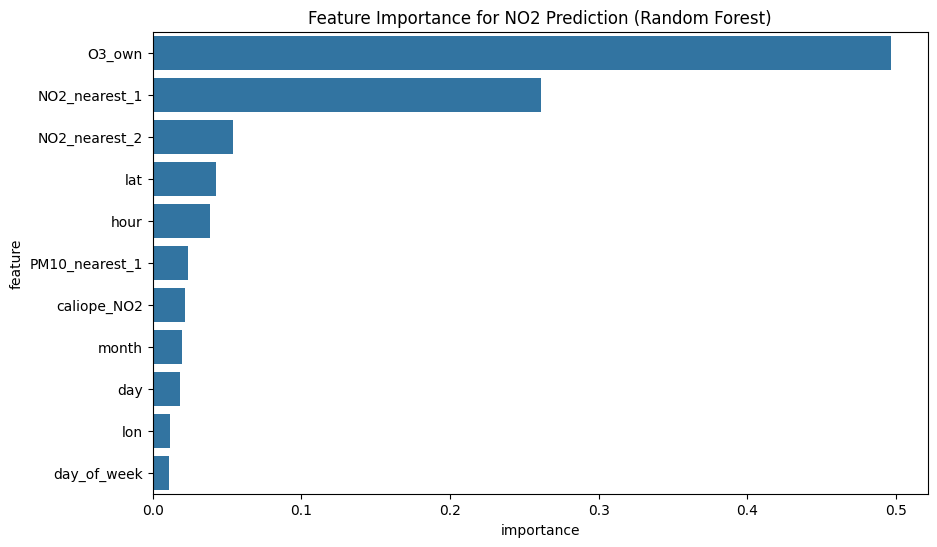

In [71]:
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# Select features and target
X = dataset_barcelona.drop(['NO2_own'], axis=1)
y = dataset_barcelona['NO2_own']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

# Support Vector Regression
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Print evaluation metrics for each model
print("Random Forest:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, rf_pred):.2f}\n')

print("XGBoost:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, xgb_pred):.2f}\n')

print("Gradient Boosting:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, gb_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, gb_pred):.2f}\n')

print("Support Vector Regression:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, svr_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, svr_pred):.2f}\n')

print("Linear Regression:")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}')
print(f'R2 Score: {r2_score(y_test, lr_pred):.2f}\n')

# Feature importance plot (using Random Forest as reference)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for NO2 Prediction (Random Forest)')
plt.show()

In [79]:
X_test_scaled = scaler.transform(dataset_barcelona_real)

xgb_pred = xgb_model.predict(X_test_scaled)


In [86]:
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'date': dataset_barcelona_real['Date'],
    'lat': dataset_barcelona_real['lat'],
    'lon': dataset_barcelona_real['lon'], 
    'concentration': xgb_pred
})



In [94]:
predictions_df.index = predictions_df.index + 1

predictions_df.to_csv('results/model_3/model_3_results_1.csv', index=True)
predictions_df

,date,lat,lon,concentration
1,2022-12-31 23:00:00,41.39216,2.009802,53.084969
2,2023-01-01 00:00:00,41.39216,2.009802,49.099747
3,2023-01-01 01:00:00,41.39216,2.009802,46.015263
4,2023-01-01 02:00:00,41.39216,2.009802,40.811440
5,2023-01-01 03:00:00,41.39216,2.009802,37.460968
...,...,...,...,...
26276,2023-12-31 18:00:00,41.32177,2.082141,35.688507
26277,2023-12-31 19:00:00,41.32177,2.082141,56.240273
26278,2023-12-31 20:00:00,41.32177,2.082141,67.618904
26279,2023-12-31 21:00:00,41.32177,2.082141,73.397728
